In [1]:
!pip install mxnet
!pip install gluonts

     |████████████████████████████████| 46.9MB 92kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 901kB 12.6MB/s 
     |████████████████████████████████| 10.1MB 52.9MB/s 


In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset

# Загружаем данные из предварительной обработки
#df = np.load('/content/drive/MyDrive/Colab Notebooks/RGD/df.npy',allow_pickle=True)
df_all = np.load('/content/drive/MyDrive/Colab Notebooks/RGD/data_all.npy',allow_pickle = True)

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [3]:
df_all

array([[831504.0, 830003, 0, ..., 0, 0, 12],
       [876100.0, 876007, 0, ..., 0, 0, 33],
       [882506.0, 880002, 0, ..., 0, 0, 0],
       ...,
       [988306.0, 970001, 10, ..., 0, 0, 0],
       [989205.0, 970001, 0, ..., 0, 0, 0],
       [989309.0, 989205, 84, ..., 0, 0, 40]], dtype=object)

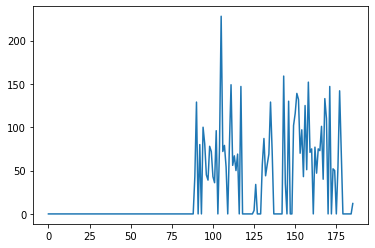

In [53]:
# Ряд для примера
df = df_all[0][2:]
plt.plot(range(0,df.shape[0]),df)

In [54]:
# Для одного ряда формируем обучающую выборку в нужном формате
date_s=[datetime.datetime(2020,7,1,0,0,0)+datetime.timedelta(hours = 4)*i for i in range(0,df.shape[0])]
train_series = pd.Series(df,index=pd.to_datetime(date_s))
#train_series.index = pd.to_datetime(date_s)
#train_series.head()
train_series.tail(20)


2020-07-28 16:00:00    101
2020-07-28 20:00:00     40
2020-07-29 00:00:00    133
2020-07-29 04:00:00    110
2020-07-29 08:00:00      0
2020-07-29 12:00:00    147
2020-07-29 16:00:00      0
2020-07-29 20:00:00     52
2020-07-30 00:00:00     50
2020-07-30 04:00:00      0
2020-07-30 08:00:00     55
2020-07-30 12:00:00    142
2020-07-30 16:00:00     72
2020-07-30 20:00:00      0
2020-07-31 00:00:00      0
2020-07-31 04:00:00      0
2020-07-31 08:00:00      0
2020-07-31 12:00:00      0
2020-07-31 16:00:00      0
2020-07-31 20:00:00     12
dtype: object

Момент с проверкой модели сразу

Идея следующая: для теста выделяем кусок в 48 позиции - все, что до используем для обучения. Тестовые точки - запуск прогноза на 48 часов вперед через каждые 24 часа, то есть 8 прогнозные ветки со смещением в 6 позиций - соответствует запуску каждые 24 часа расчета.

In [55]:
# Для теста указывается весь уже датасет
# Для обучения задается датасет, за исключением того, на сколько надо предсказать
training_data = ListDataset(
    [{"start": train_series.index[0], "target": train_series[:-48]}],
    freq = "4H"
)

# Тестовые данные без пересечения с тренировочными
test_data_ev = ListDataset(
    [{"start": train_series.index[0], "target": train_series[:-42]},
     {"start": train_series.index[0], "target": train_series[:-36]},
     {"start": train_series.index[0], "target": train_series[:-30]},
     {"start": train_series.index[0], "target": train_series[:-24]},
     {"start": train_series.index[0], "target": train_series[:-18]},
     {"start": train_series.index[0], "target": train_series[:-12]},
     {"start": train_series.index[0], "target": train_series[:-6]},
     {"start": train_series.index[0], "target": train_series}],
    freq = "4H"
)

In [56]:
# Обучаем наш предиктор на train - предсказываем на 12 позиций вперед с частотой 4 часа
estimator = DeepAREstimator(freq="4H",
                            num_layers = 5,
                            num_cells = 40,
                            prediction_length=10,
                            trainer=Trainer(epochs=10,ctx="cpu",),
                            batch_size=32,
                            dropout_rate = 0.3
                            )
predictor = estimator.train(training_data=training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:03<00:00, 13.83it/s, epoch=10/10, avg_epoch_loss=1.98]


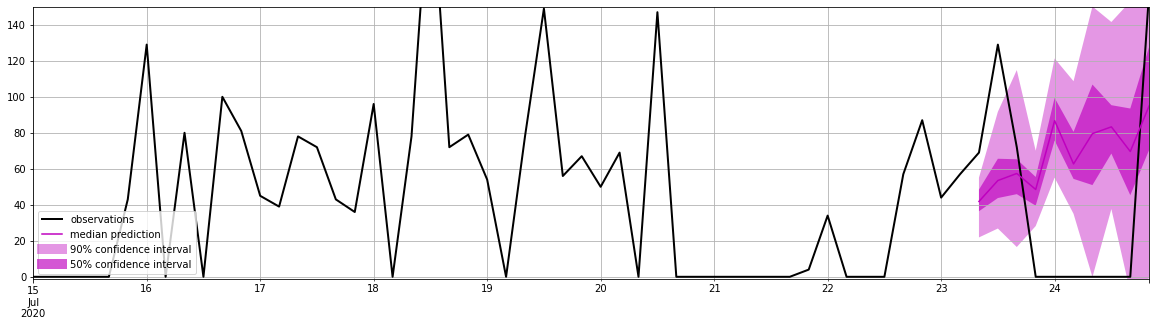

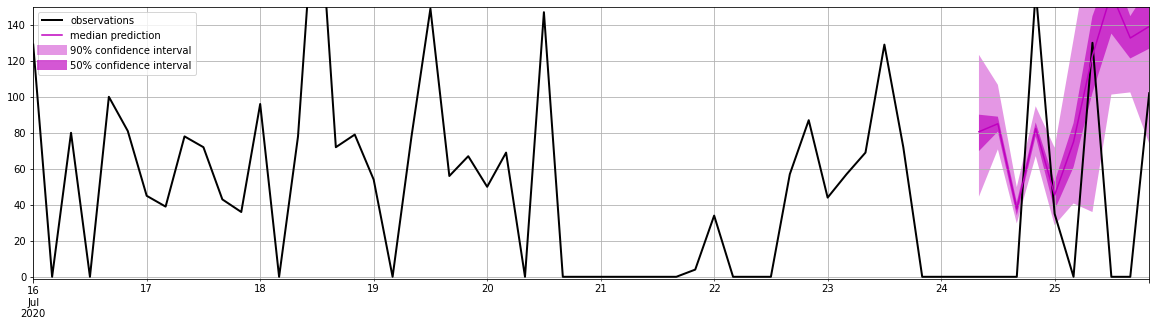

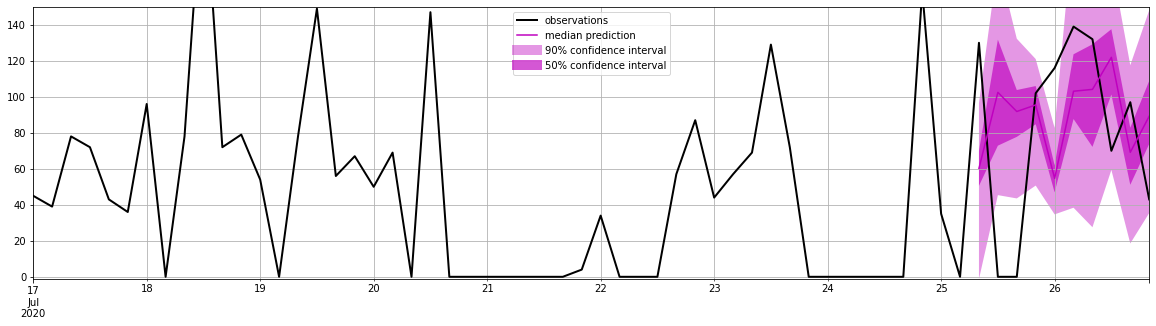

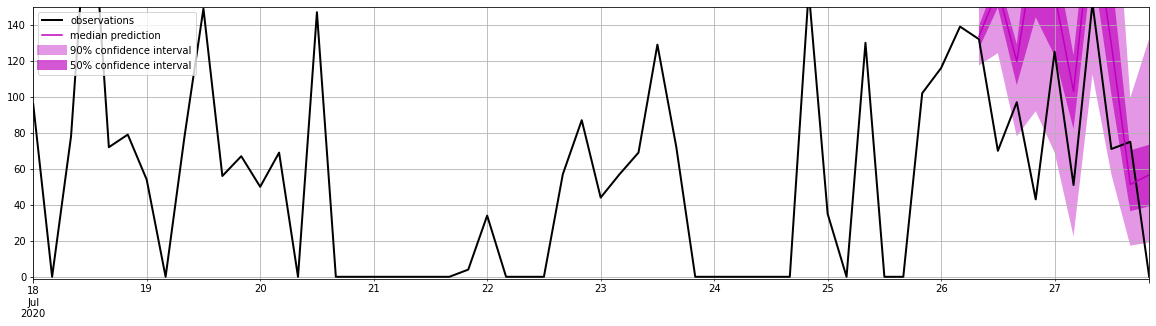

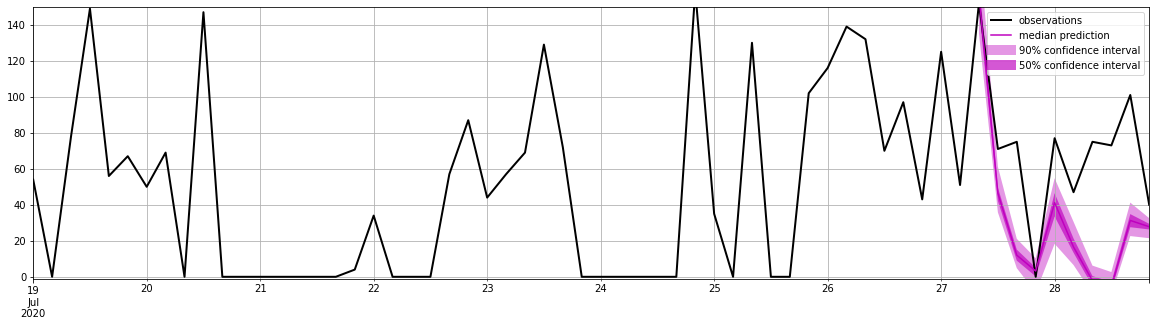

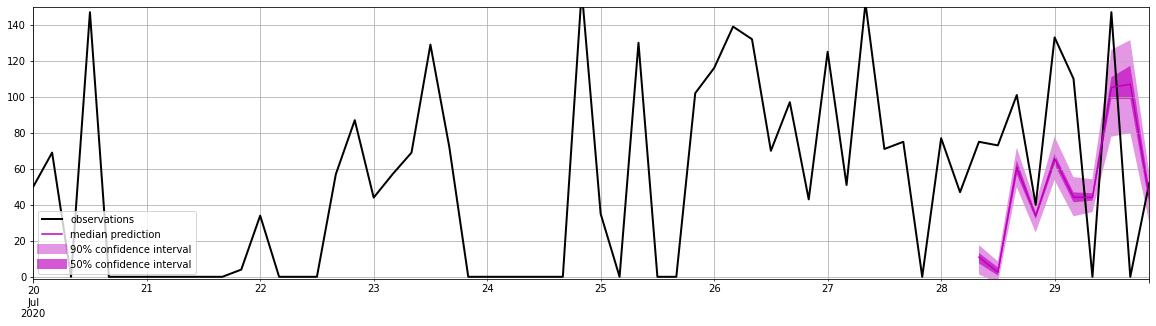

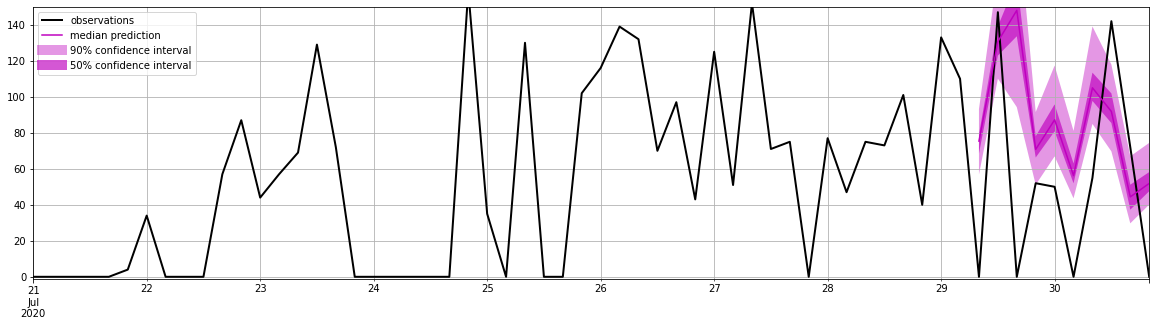

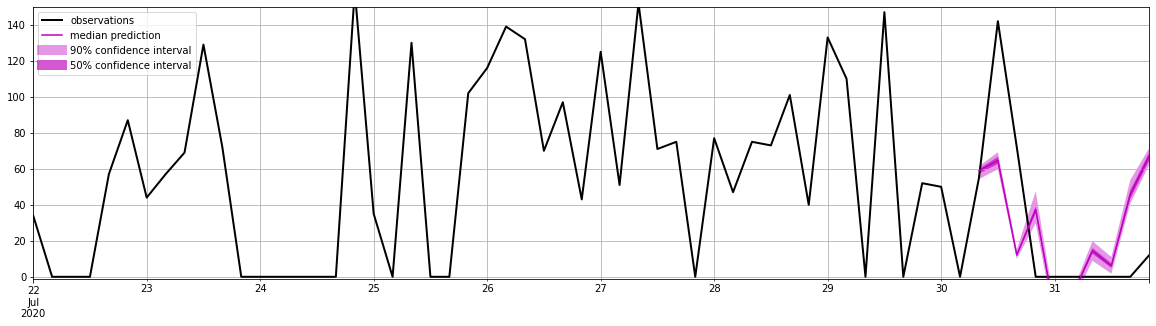

In [59]:
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

# Визуализируем предсказания с 50 и 90 квантилем
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(20, 5), linewidth=2,color = 'k')
        forecast.plot(color='m',)
        plt.grid(which='both')
        plt.ylim((-1,150))
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_data_ev, predictor=predictor, num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=60, num_plots=8)

In [58]:
# Смотрим на полученные метрики
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=8)
print(f"RMSE = {agg_metrics['RMSE']}")


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 439.81it/s]

RMSE = 61.34011666201308


In [ ]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/content/drive/MyDrive/Colab Notebooks/RGD"))

# loads it back
#from gluonts.model.predictor import Predictor
#predictor_deserialized = Predictor.deserialize(Path("/content/drive/MyDrive/Colab Notebooks/RGD/"))

In [ ]:
# Обучаем наш предиктор на train - предсказываем на 12 позиций вперед с частотой 4 часа
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer
# Сеть прямого распространения
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[128,64],
    batch_normalization=True,
    prediction_length=12,
    freq="4H",
    trainer=Trainer(
        ctx="cpu",
        epochs=50,
        learning_rate=1e-3,
        hybridize=True,
        num_batches_per_epoch=32
    )
)
predictor = estimator.train(training_data=training_data)

Теперь закинем все наши ряды в эти предикторы, обучим каждый из них, сохраним каждый из них в папку и посчитаем среднее значение некоторых метрик для всех рядов.

In [ ]:
MAPE_all = []
MAE_all = []
RMSE_all = []
for num_var in tqdm(range(0,df_all.shape[0])):
  df = df_all[num_var][2:]
  #plt.plot(range(0,df.shape[0]),df)
  date_s=[datetime.datetime(2020,7,1,0,0,0)+datetime.timedelta(hours = 4)*i for i in range(0,df.shape[0])]
  train_series = pd.Series(df,index=pd.to_datetime(date_s))
  # Для теста указывается весь уже датасет
  # Для обучения задается датасет, за исключением того, на сколько надо предсказать
  training_data = ListDataset(
      [{"start": train_series.index[0], "target": train_series[:-48]}],
      freq = "4H"
  )

  # Тестовые данные без пересечения с тренировочными
  test_data_ev = ListDataset(
      [{"start": train_series.index[0], "target": train_series[:-42]},
      {"start": train_series.index[0], "target": train_series[:-36]},
      {"start": train_series.index[0], "target": train_series[:-30]},
      {"start": train_series.index[0], "target": train_series[:-24]},
      {"start": train_series.index[0], "target": train_series[:-18]},
      {"start": train_series.index[0], "target": train_series[:-12]},
      {"start": train_series.index[0], "target": train_series[:-6]},
      {"start": train_series.index[0], "target": train_series}],
      freq = "4H"
  )

  # Обучаем наш предиктор на train - предсказываем на 12 позиций вперед с частотой 4 часа
  estimator = DeepAREstimator(freq="4H",
                              num_layers = 5,
                              num_cells = 40,
                              prediction_length=12,
                              trainer=Trainer(epochs=10,ctx="cpu",),
                              batch_size=32,
                              dropout_rate = 0.3
                              )
  predictor = estimator.train(training_data=training_data)

  forecast_it, ts_it = make_evaluation_predictions(test_data_ev, predictor=predictor, num_samples=100)
  forecasts = list(forecast_it)
  tss = list(ts_it)

  evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
  agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=8)
  MAPE_all.append(agg_metrics['MAPE'])
  MAE_all.append(agg_metrics['MAE_Coverage'])
  RMSE_all.append(agg_metrics['RMSE'])
  # Сохраняем предиктор - в качестве имени station_operation:station_destination
  
  predictor_folder = "/content/drive/MyDrive/Colab Notebooks/RGD/Gluonts_predictors/"+str(df_all[num_var][0]) +":"+ str(df_all[num_var][1])
  if not os.path.exists(predictor_folder):
    os.mkdir(predictor_folder)
  predictor.serialize(Path(predictor_folder))


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.44it/s, epoch=1/10, avg_epoch_loss=3.05]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=2/10, avg_epoch_loss=2.78]


100%|██████████| 50/50 [00:05<00:00,  9.14it/s, epoch=3/10, avg_epoch_loss=2.41]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=4/10, avg_epoch_loss=2.13]


100%|██████████| 50/50 [00:05<00:00,  9.14it/s, epoch=5/10, avg_epoch_loss=1.9]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=6/10, avg_epoch_loss=2.2]


100%|██████████| 50/50 [00:05<00:00,  9.15it/s, epoch=7/10, avg_epoch_loss=1.93]


100%|██████████| 50/50 [00:05<00:00,  9.12it/s, epoch=8/10, avg_epoch_loss=2.11]


100%|██████████| 50/50 [00:05<00:00,  9.17it/s, epoch=9/10, avg_epoch_loss=1.77]


100%|██████████| 50/50 [00:05<00:00,  9.07it/s, epoch=10/10, avg_epoch_loss=1.66]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 193.40it/s]

  3%|▎         | 1/39 [00:56<35:43, 56.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.53it/s, epoch=1/10, avg_epoch_loss=1.18]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=2/10, avg_epoch_loss=0.39]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=3/10, avg_epoch_loss=0.251]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=4/10, avg_epoch_loss=0.238]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=5/10, avg_epoch_loss=0.352]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=6/10, avg_epoch_loss=0.0161]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=7/10, avg_epoch_loss=0.307]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=8/10, avg_epoch_loss=-.359]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=9/10, avg_epoch_loss=0.0897]


100%|██████████| 50/50 [00:05<00:00,  9.13it/s, epoch=10/10, avg_epoch_loss=-.417]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 200.37it/s]

  5%|▌         | 2/39 [01:52<34:48, 56.46s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.53it/s, epoch=1/10, avg_epoch_loss=3.25]


100%|██████████| 50/50 [00:05<00:00,  9.11it/s, epoch=2/10, avg_epoch_loss=2.64]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=3/10, avg_epoch_loss=2.31]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=4/10, avg_epoch_loss=2.03]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=5/10, avg_epoch_loss=1.83]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=6/10, avg_epoch_loss=1.68]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=7/10, avg_epoch_loss=1.49]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=8/10, avg_epoch_loss=1.39]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=9/10, avg_epoch_loss=1.24]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=10/10, avg_epoch_loss=1.19]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 225.93it/s]

  8%|▊         | 3/39 [02:49<33:54, 56.51s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.53it/s, epoch=1/10, avg_epoch_loss=3.08]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=2/10, avg_epoch_loss=2.4]


100%|██████████| 50/50 [00:05<00:00,  9.10it/s, epoch=3/10, avg_epoch_loss=1.98]


100%|██████████| 50/50 [00:05<00:00,  9.07it/s, epoch=4/10, avg_epoch_loss=1.63]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=5/10, avg_epoch_loss=1.4]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=6/10, avg_epoch_loss=1.19]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=7/10, avg_epoch_loss=1.07]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=8/10, avg_epoch_loss=1.03]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=9/10, avg_epoch_loss=0.94]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=10/10, avg_epoch_loss=0.853]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 219.15it/s]

 10%|█         | 4/39 [03:46<33:00, 56.57s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.51it/s, epoch=1/10, avg_epoch_loss=3.02]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=2/10, avg_epoch_loss=2.38]


100%|██████████| 50/50 [00:05<00:00,  9.12it/s, epoch=3/10, avg_epoch_loss=2.12]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=4/10, avg_epoch_loss=1.76]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=5/10, avg_epoch_loss=1.56]


100%|██████████| 50/50 [00:05<00:00,  9.12it/s, epoch=6/10, avg_epoch_loss=1.44]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=7/10, avg_epoch_loss=1.14]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=8/10, avg_epoch_loss=0.984]


100%|██████████| 50/50 [00:05<00:00,  9.07it/s, epoch=9/10, avg_epoch_loss=0.951]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=10/10, avg_epoch_loss=0.801]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 185.01it/s]

 13%|█▎        | 5/39 [04:43<32:04, 56.60s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.53it/s, epoch=1/10, avg_epoch_loss=2.89]


100%|██████████| 50/50 [00:05<00:00,  9.07it/s, epoch=2/10, avg_epoch_loss=2.22]


100%|██████████| 50/50 [00:05<00:00,  9.11it/s, epoch=3/10, avg_epoch_loss=1.88]


100%|██████████| 50/50 [00:05<00:00,  9.13it/s, epoch=4/10, avg_epoch_loss=1.74]


100%|██████████| 50/50 [00:05<00:00,  9.11it/s, epoch=5/10, avg_epoch_loss=1.42]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=6/10, avg_epoch_loss=1.25]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=7/10, avg_epoch_loss=1.13]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=8/10, avg_epoch_loss=1.12]


100%|██████████| 50/50 [00:05<00:00,  9.11it/s, epoch=9/10, avg_epoch_loss=1.02]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=10/10, avg_epoch_loss=0.913]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 208.83it/s]

 15%|█▌        | 6/39 [05:39<31:05, 56.53s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.46it/s, epoch=1/10, avg_epoch_loss=4.76]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=2/10, avg_epoch_loss=4.05]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=3/10, avg_epoch_loss=3.54]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=4/10, avg_epoch_loss=3.19]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=5/10, avg_epoch_loss=3.08]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=6/10, avg_epoch_loss=2.95]


100%|██████████| 50/50 [00:05<00:00,  9.07it/s, epoch=7/10, avg_epoch_loss=2.74]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=8/10, avg_epoch_loss=2.71]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=9/10, avg_epoch_loss=2.56]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=10/10, avg_epoch_loss=2.6]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 205.94it/s]

 18%|█▊        | 7/39 [06:36<30:10, 56.59s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.54it/s, epoch=1/10, avg_epoch_loss=3.97]


100%|██████████| 50/50 [00:05<00:00,  9.07it/s, epoch=2/10, avg_epoch_loss=3.26]


100%|██████████| 50/50 [00:05<00:00,  9.12it/s, epoch=3/10, avg_epoch_loss=2.75]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=4/10, avg_epoch_loss=2.45]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=5/10, avg_epoch_loss=2.21]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=6/10, avg_epoch_loss=1.99]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=7/10, avg_epoch_loss=1.86]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=8/10, avg_epoch_loss=1.74]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=9/10, avg_epoch_loss=1.67]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=10/10, avg_epoch_loss=1.54]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 194.81it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1625: UserWarning: Warning: converti

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.54it/s, epoch=1/10, avg_epoch_loss=3.97]


100%|██████████| 50/50 [00:05<00:00,  9.11it/s, epoch=2/10, avg_epoch_loss=3.34]


100%|██████████| 50/50 [00:05<00:00,  9.13it/s, epoch=3/10, avg_epoch_loss=2.92]


100%|██████████| 50/50 [00:05<00:00,  9.07it/s, epoch=4/10, avg_epoch_loss=2.64]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=5/10, avg_epoch_loss=2.38]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=6/10, avg_epoch_loss=2.25]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=7/10, avg_epoch_loss=2.05]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=8/10, avg_epoch_loss=1.94]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=9/10, avg_epoch_loss=1.76]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=10/10, avg_epoch_loss=1.66]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 172.79it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1625: UserWarning: Warning: converti

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.44it/s, epoch=1/10, avg_epoch_loss=1.79]


100%|██████████| 50/50 [00:05<00:00,  8.62it/s, epoch=2/10, avg_epoch_loss=0.982]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=3/10, avg_epoch_loss=0.662]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=4/10, avg_epoch_loss=0.372]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=5/10, avg_epoch_loss=0.101]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=6/10, avg_epoch_loss=-.00684]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=7/10, avg_epoch_loss=-.17]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=8/10, avg_epoch_loss=-.253]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=9/10, avg_epoch_loss=-.416]


100%|██████████| 50/50 [00:05<00:00,  8.84it/s, epoch=10/10, avg_epoch_loss=-.51]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 184.99it/s]

 26%|██▌       | 10/39 [09:26<27:26, 56.78s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.43it/s, epoch=1/10, avg_epoch_loss=4.29]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=2/10, avg_epoch_loss=3.71]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=3/10, avg_epoch_loss=3.23]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=4/10, avg_epoch_loss=2.95]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=5/10, avg_epoch_loss=2.63]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=6/10, avg_epoch_loss=2.43]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=7/10, avg_epoch_loss=2.27]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=8/10, avg_epoch_loss=2.21]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=9/10, avg_epoch_loss=2.05]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=10/10, avg_epoch_loss=1.99]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 187.52it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1625: UserWarning: Warning: converti

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.43it/s, epoch=1/10, avg_epoch_loss=4.13]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=2/10, avg_epoch_loss=3.63]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=3/10, avg_epoch_loss=3.16]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=4/10, avg_epoch_loss=2.87]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=5/10, avg_epoch_loss=2.67]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=6/10, avg_epoch_loss=2.4]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=7/10, avg_epoch_loss=2.22]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=8/10, avg_epoch_loss=2.01]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=9/10, avg_epoch_loss=1.95]


100%|██████████| 50/50 [00:05<00:00,  8.92it/s, epoch=10/10, avg_epoch_loss=1.84]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 166.46it/s]

 31%|███       | 12/39 [11:20<25:37, 56.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.47it/s, epoch=1/10, avg_epoch_loss=2.62]


100%|██████████| 50/50 [00:05<00:00,  8.92it/s, epoch=2/10, avg_epoch_loss=2.17]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=3/10, avg_epoch_loss=1.95]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=4/10, avg_epoch_loss=1.65]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=5/10, avg_epoch_loss=1.34]


100%|██████████| 50/50 [00:05<00:00,  8.92it/s, epoch=6/10, avg_epoch_loss=1.32]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=7/10, avg_epoch_loss=1.22]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=8/10, avg_epoch_loss=1.07]


100%|██████████| 50/50 [00:05<00:00,  8.90it/s, epoch=9/10, avg_epoch_loss=1.04]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=10/10, avg_epoch_loss=0.856]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 191.49it/s]

 33%|███▎      | 13/39 [12:17<24:41, 56.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.45it/s, epoch=1/10, avg_epoch_loss=2.73]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=2/10, avg_epoch_loss=2.4]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=3/10, avg_epoch_loss=2.1]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=4/10, avg_epoch_loss=1.98]


100%|██████████| 50/50 [00:05<00:00,  9.10it/s, epoch=5/10, avg_epoch_loss=1.76]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=6/10, avg_epoch_loss=1.75]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=7/10, avg_epoch_loss=1.61]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=8/10, avg_epoch_loss=1.41]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=9/10, avg_epoch_loss=1.35]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=10/10, avg_epoch_loss=1.29]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 171.04it/s]

 36%|███▌      | 14/39 [13:14<23:44, 56.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.50it/s, epoch=1/10, avg_epoch_loss=2.48]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=2/10, avg_epoch_loss=1.77]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=3/10, avg_epoch_loss=1.22]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=4/10, avg_epoch_loss=0.975]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=5/10, avg_epoch_loss=0.841]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=6/10, avg_epoch_loss=0.73]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=7/10, avg_epoch_loss=0.405]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=8/10, avg_epoch_loss=0.467]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=9/10, avg_epoch_loss=0.32]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=10/10, avg_epoch_loss=0.161]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 205.65it/s]

 38%|███▊      | 15/39 [14:11<22:47, 56.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.49it/s, epoch=1/10, avg_epoch_loss=4.24]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=2/10, avg_epoch_loss=3.42]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=3/10, avg_epoch_loss=2.95]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=4/10, avg_epoch_loss=2.64]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=5/10, avg_epoch_loss=2.4]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=6/10, avg_epoch_loss=2.33]


100%|██████████| 50/50 [00:05<00:00,  8.89it/s, epoch=7/10, avg_epoch_loss=2.06]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=8/10, avg_epoch_loss=2]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=9/10, avg_epoch_loss=1.94]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=10/10, avg_epoch_loss=1.8]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 154.38it/s]

 41%|████      | 16/39 [15:08<21:51, 57.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.48it/s, epoch=1/10, avg_epoch_loss=4.02]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=2/10, avg_epoch_loss=3.48]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=3/10, avg_epoch_loss=2.99]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=4/10, avg_epoch_loss=2.66]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=5/10, avg_epoch_loss=2.39]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=6/10, avg_epoch_loss=2.17]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=7/10, avg_epoch_loss=2.02]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=8/10, avg_epoch_loss=1.85]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=9/10, avg_epoch_loss=1.62]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=10/10, avg_epoch_loss=1.46]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 226.35it/s]

 44%|████▎     | 17/39 [16:05<20:54, 57.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.43it/s, epoch=1/10, avg_epoch_loss=3.86]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=2/10, avg_epoch_loss=3.2]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=3/10, avg_epoch_loss=2.78]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=4/10, avg_epoch_loss=2.4]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=5/10, avg_epoch_loss=2.1]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=6/10, avg_epoch_loss=1.91]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=7/10, avg_epoch_loss=1.74]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=8/10, avg_epoch_loss=1.64]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=9/10, avg_epoch_loss=1.72]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=10/10, avg_epoch_loss=1.49]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 218.56it/s]

 46%|████▌     | 18/39 [17:02<19:57, 57.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.49it/s, epoch=1/10, avg_epoch_loss=2.28]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=2/10, avg_epoch_loss=1.49]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=3/10, avg_epoch_loss=0.929]


100%|██████████| 50/50 [00:05<00:00,  8.90it/s, epoch=4/10, avg_epoch_loss=0.627]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=5/10, avg_epoch_loss=0.431]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=6/10, avg_epoch_loss=0.355]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=7/10, avg_epoch_loss=0.192]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=8/10, avg_epoch_loss=-.00248]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=9/10, avg_epoch_loss=-.0771]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=10/10, avg_epoch_loss=-.0861]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 192.56it/s]

 49%|████▊     | 19/39 [17:59<19:00, 57.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.49it/s, epoch=1/10, avg_epoch_loss=2.34]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=2/10, avg_epoch_loss=1.62]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=3/10, avg_epoch_loss=1.18]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=4/10, avg_epoch_loss=0.852]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=5/10, avg_epoch_loss=0.637]


100%|██████████| 50/50 [00:05<00:00,  9.10it/s, epoch=6/10, avg_epoch_loss=0.439]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=7/10, avg_epoch_loss=0.345]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=8/10, avg_epoch_loss=0.176]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=9/10, avg_epoch_loss=0.0829]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=10/10, avg_epoch_loss=-.00149]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 209.02it/s]

 51%|█████▏    | 20/39 [18:56<18:02, 56.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.45it/s, epoch=1/10, avg_epoch_loss=5.02]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=2/10, avg_epoch_loss=4.52]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=3/10, avg_epoch_loss=4.18]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=4/10, avg_epoch_loss=3.96]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=5/10, avg_epoch_loss=3.72]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=6/10, avg_epoch_loss=3.54]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=7/10, avg_epoch_loss=3.39]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=8/10, avg_epoch_loss=3.25]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=9/10, avg_epoch_loss=3.12]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=10/10, avg_epoch_loss=3.07]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 213.02it/s]

 54%|█████▍    | 21/39 [19:53<17:05, 56.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.40it/s, epoch=1/10, avg_epoch_loss=2.14]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=2/10, avg_epoch_loss=1.5]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=3/10, avg_epoch_loss=1.05]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=4/10, avg_epoch_loss=0.837]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=5/10, avg_epoch_loss=0.534]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=6/10, avg_epoch_loss=0.377]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=7/10, avg_epoch_loss=0.35]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=8/10, avg_epoch_loss=0.0977]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=9/10, avg_epoch_loss=0.0476]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=10/10, avg_epoch_loss=0.0405]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 172.37it/s]

 56%|█████▋    | 22/39 [20:50<16:08, 56.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.42it/s, epoch=1/10, avg_epoch_loss=3.47]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=2/10, avg_epoch_loss=2.86]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=3/10, avg_epoch_loss=2.47]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=4/10, avg_epoch_loss=2.13]


100%|██████████| 50/50 [00:05<00:00,  9.07it/s, epoch=5/10, avg_epoch_loss=1.86]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=6/10, avg_epoch_loss=1.55]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=7/10, avg_epoch_loss=1.34]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=8/10, avg_epoch_loss=1.13]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=9/10, avg_epoch_loss=0.987]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=10/10, avg_epoch_loss=0.889]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 202.36it/s]

 59%|█████▉    | 23/39 [21:47<15:10, 56.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.52it/s, epoch=1/10, avg_epoch_loss=5.04]


100%|██████████| 50/50 [00:05<00:00,  8.93it/s, epoch=2/10, avg_epoch_loss=4.69]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=3/10, avg_epoch_loss=4.37]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=4/10, avg_epoch_loss=4.15]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=5/10, avg_epoch_loss=3.97]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=6/10, avg_epoch_loss=3.84]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=7/10, avg_epoch_loss=3.67]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=8/10, avg_epoch_loss=3.62]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=9/10, avg_epoch_loss=3.55]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=10/10, avg_epoch_loss=3.44]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 189.82it/s]

 62%|██████▏   | 24/39 [22:44<14:14, 56.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.53it/s, epoch=1/10, avg_epoch_loss=3.74]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=2/10, avg_epoch_loss=3.02]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=3/10, avg_epoch_loss=2.61]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=4/10, avg_epoch_loss=2.25]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=5/10, avg_epoch_loss=2.05]


100%|██████████| 50/50 [00:05<00:00,  9.11it/s, epoch=6/10, avg_epoch_loss=1.86]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=7/10, avg_epoch_loss=1.71]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=8/10, avg_epoch_loss=1.7]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=9/10, avg_epoch_loss=1.56]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=10/10, avg_epoch_loss=1.4]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 191.93it/s]

 64%|██████▍   | 25/39 [23:41<13:16, 56.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.43it/s, epoch=1/10, avg_epoch_loss=2.4]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=2/10, avg_epoch_loss=1.67]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=3/10, avg_epoch_loss=1.4]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=4/10, avg_epoch_loss=1.14]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=5/10, avg_epoch_loss=0.914]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=6/10, avg_epoch_loss=0.813]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=7/10, avg_epoch_loss=0.631]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=8/10, avg_epoch_loss=0.463]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=9/10, avg_epoch_loss=0.346]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=10/10, avg_epoch_loss=0.266]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 213.59it/s]

 67%|██████▋   | 26/39 [24:38<12:19, 56.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.55it/s, epoch=1/10, avg_epoch_loss=1.8]


100%|██████████| 50/50 [00:05<00:00,  8.93it/s, epoch=2/10, avg_epoch_loss=1.07]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=3/10, avg_epoch_loss=0.64]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=4/10, avg_epoch_loss=0.485]


100%|██████████| 50/50 [00:05<00:00,  9.09it/s, epoch=5/10, avg_epoch_loss=0.264]


100%|██████████| 50/50 [00:05<00:00,  9.07it/s, epoch=6/10, avg_epoch_loss=0.0792]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=7/10, avg_epoch_loss=0.00791]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=8/10, avg_epoch_loss=-.112]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=9/10, avg_epoch_loss=-.268]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=10/10, avg_epoch_loss=-.356]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 196.97it/s]

 69%|██████▉   | 27/39 [25:35<11:22, 56.89s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.51it/s, epoch=1/10, avg_epoch_loss=2.66]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=2/10, avg_epoch_loss=1.83]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=3/10, avg_epoch_loss=1.33]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=4/10, avg_epoch_loss=1.08]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=5/10, avg_epoch_loss=0.821]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=6/10, avg_epoch_loss=0.687]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=7/10, avg_epoch_loss=0.532]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=8/10, avg_epoch_loss=0.486]


100%|██████████| 50/50 [00:05<00:00,  9.11it/s, epoch=9/10, avg_epoch_loss=0.335]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=10/10, avg_epoch_loss=0.186]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 183.36it/s]

 72%|███████▏  | 28/39 [26:31<10:25, 56.85s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.44it/s, epoch=1/10, avg_epoch_loss=2.61]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=2/10, avg_epoch_loss=1.86]


100%|██████████| 50/50 [00:05<00:00,  8.99it/s, epoch=3/10, avg_epoch_loss=1.49]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=4/10, avg_epoch_loss=1.19]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=5/10, avg_epoch_loss=1.01]


100%|██████████| 50/50 [00:05<00:00,  8.98it/s, epoch=6/10, avg_epoch_loss=0.857]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=7/10, avg_epoch_loss=0.718]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=8/10, avg_epoch_loss=0.7]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=9/10, avg_epoch_loss=0.542]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=10/10, avg_epoch_loss=0.407]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 193.68it/s]

 74%|███████▍  | 29/39 [27:28<09:28, 56.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.41it/s, epoch=1/10, avg_epoch_loss=1.42]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=2/10, avg_epoch_loss=0.677]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=3/10, avg_epoch_loss=0.259]


100%|██████████| 50/50 [00:05<00:00,  8.91it/s, epoch=4/10, avg_epoch_loss=-.00659]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=5/10, avg_epoch_loss=-.26]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=6/10, avg_epoch_loss=-.441]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=7/10, avg_epoch_loss=-.564]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=8/10, avg_epoch_loss=-.667]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=9/10, avg_epoch_loss=-.765]


100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=10/10, avg_epoch_loss=-.858]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 179.02it/s]

 77%|███████▋  | 30/39 [28:25<08:32, 56.90s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.46it/s, epoch=1/10, avg_epoch_loss=2.61]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=2/10, avg_epoch_loss=1.91]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=3/10, avg_epoch_loss=1.51]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=4/10, avg_epoch_loss=1.21]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=5/10, avg_epoch_loss=1.03]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=6/10, avg_epoch_loss=0.871]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=7/10, avg_epoch_loss=0.832]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=8/10, avg_epoch_loss=0.642]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=9/10, avg_epoch_loss=0.583]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=10/10, avg_epoch_loss=0.489]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 189.75it/s]

 79%|███████▉  | 31/39 [29:22<07:34, 56.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.47it/s, epoch=1/10, avg_epoch_loss=2.35]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=2/10, avg_epoch_loss=1.72]


100%|██████████| 50/50 [00:05<00:00,  9.13it/s, epoch=3/10, avg_epoch_loss=1.37]


100%|██████████| 50/50 [00:05<00:00,  9.04it/s, epoch=4/10, avg_epoch_loss=1.1]


100%|██████████| 50/50 [00:05<00:00,  8.75it/s, epoch=5/10, avg_epoch_loss=0.919]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=6/10, avg_epoch_loss=0.739]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=7/10, avg_epoch_loss=0.659]


100%|██████████| 50/50 [00:05<00:00,  9.05it/s, epoch=8/10, avg_epoch_loss=0.569]


100%|██████████| 50/50 [00:05<00:00,  9.08it/s, epoch=9/10, avg_epoch_loss=0.416]


100%|██████████| 50/50 [00:05<00:00,  9.06it/s, epoch=10/10, avg_epoch_loss=0.376]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 159.81it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1625: UserWarning: Warning: con

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.40it/s, epoch=1/10, avg_epoch_loss=2.12]


100%|██████████| 50/50 [00:05<00:00,  8.90it/s, epoch=2/10, avg_epoch_loss=1.38]


100%|██████████| 50/50 [00:05<00:00,  8.96it/s, epoch=3/10, avg_epoch_loss=1.02]


100%|██████████| 50/50 [00:05<00:00,  9.00it/s, epoch=4/10, avg_epoch_loss=0.761]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=5/10, avg_epoch_loss=0.498]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=6/10, avg_epoch_loss=0.349]


100%|██████████| 50/50 [00:05<00:00,  8.94it/s, epoch=7/10, avg_epoch_loss=0.206]


100%|██████████| 50/50 [00:05<00:00,  8.97it/s, epoch=8/10, avg_epoch_loss=0.0463]


100%|██████████| 50/50 [00:05<00:00,  8.89it/s, epoch=9/10, avg_epoch_loss=0.0358]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=10/10, avg_epoch_loss=-.15]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 224.36it/s]

 85%|████████▍ | 33/39 [31:16<05:42, 57.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  8.43it/s, epoch=1/10, avg_epoch_loss=4.13]


100%|██████████| 50/50 [00:05<00:00,  8.95it/s, epoch=2/10, avg_epoch_loss=3.7]


100%|██████████| 50/50 [00:05<00:00,  9.03it/s, epoch=3/10, avg_epoch_loss=3.37]


100%|██████████| 50/50 [00:05<00:00,  9.02it/s, epoch=4/10, avg_epoch_loss=3.11]


100%|██████████| 50/50 [00:05<00:00,  8.81it/s, epoch=5/10, avg_epoch_loss=2.91]


100%|██████████| 50/50 [00:05<00:00,  8.70it/s, epoch=6/10, avg_epoch_loss=2.75]


100%|██████████| 50/50 [00:05<00:00,  8.75it/s, epoch=7/10, avg_epoch_loss=2.59]


100%|██████████| 50/50 [00:05<00:00,  8.70it/s, epoch=8/10, avg_epoch_loss=2.46]


100%|██████████| 50/50 [00:05<00:00,  8.65it/s, epoch=9/10, avg_epoch_loss=2.39]


100%|██████████| 50/50 [00:05<00:00,  8.56it/s, epoch=10/10, avg_epoch_loss=2.24]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 146.04it/s]

 87%|████████▋ | 34/39 [32:15<04:47, 57.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:06<00:00,  8.04it/s, epoch=1/10, avg_epoch_loss=2.88]


100%|██████████| 50/50 [00:05<00:00,  8.42it/s, epoch=2/10, avg_epoch_loss=2.27]


100%|██████████| 50/50 [00:05<00:00,  8.60it/s, epoch=3/10, avg_epoch_loss=1.85]


100%|██████████| 50/50 [00:05<00:00,  8.80it/s, epoch=4/10, avg_epoch_loss=1.51]


100%|██████████| 50/50 [00:05<00:00,  8.60it/s, epoch=5/10, avg_epoch_loss=1.28]


100%|██████████| 50/50 [00:05<00:00,  8.56it/s, epoch=6/10, avg_epoch_loss=1.08]


100%|██████████| 50/50 [00:05<00:00,  8.78it/s, epoch=7/10, avg_epoch_loss=0.97]


100%|██████████| 50/50 [00:05<00:00,  8.38it/s, epoch=8/10, avg_epoch_loss=0.898]


100%|██████████| 50/50 [00:05<00:00,  8.70it/s, epoch=9/10, avg_epoch_loss=0.774]


100%|██████████| 50/50 [00:05<00:00,  8.48it/s, epoch=10/10, avg_epoch_loss=0.706]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 185.38it/s]

 90%|████████▉ | 35/39 [33:14<03:52, 58.11s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:06<00:00,  7.86it/s, epoch=1/10, avg_epoch_loss=1.46]


100%|██████████| 50/50 [00:05<00:00,  8.66it/s, epoch=2/10, avg_epoch_loss=0.842]


100%|██████████| 50/50 [00:05<00:00,  8.48it/s, epoch=3/10, avg_epoch_loss=0.354]


100%|██████████| 50/50 [00:05<00:00,  8.44it/s, epoch=4/10, avg_epoch_loss=0.0848]


100%|██████████| 50/50 [00:05<00:00,  8.38it/s, epoch=5/10, avg_epoch_loss=-.126]


100%|██████████| 50/50 [00:05<00:00,  8.62it/s, epoch=6/10, avg_epoch_loss=-.35]


100%|██████████| 50/50 [00:05<00:00,  8.54it/s, epoch=7/10, avg_epoch_loss=-.478]


100%|██████████| 50/50 [00:06<00:00,  8.32it/s, epoch=8/10, avg_epoch_loss=-.625]


100%|██████████| 50/50 [00:05<00:00,  8.56it/s, epoch=9/10, avg_epoch_loss=-.581]


100%|██████████| 50/50 [00:05<00:00,  8.85it/s, epoch=10/10, avg_epoch_loss=-.76]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 145.45it/s]

 92%|█████████▏| 36/39 [34:15<02:56, 58.79s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:06<00:00,  7.90it/s, epoch=1/10, avg_epoch_loss=3.1]


100%|██████████| 50/50 [00:05<00:00,  8.57it/s, epoch=2/10, avg_epoch_loss=2.56]


100%|██████████| 50/50 [00:05<00:00,  8.61it/s, epoch=3/10, avg_epoch_loss=2.25]


100%|██████████| 50/50 [00:05<00:00,  8.73it/s, epoch=4/10, avg_epoch_loss=1.99]


100%|██████████| 50/50 [00:05<00:00,  8.52it/s, epoch=5/10, avg_epoch_loss=1.83]


100%|██████████| 50/50 [00:06<00:00,  8.23it/s, epoch=6/10, avg_epoch_loss=1.68]


100%|██████████| 50/50 [00:05<00:00,  8.48it/s, epoch=7/10, avg_epoch_loss=1.55]


100%|██████████| 50/50 [00:06<00:00,  8.03it/s, epoch=8/10, avg_epoch_loss=1.48]


100%|██████████| 50/50 [00:05<00:00,  8.45it/s, epoch=9/10, avg_epoch_loss=1.36]


100%|██████████| 50/50 [00:05<00:00,  8.63it/s, epoch=10/10, avg_epoch_loss=1.2]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 176.57it/s]

 95%|█████████▍| 37/39 [35:15<01:58, 59.32s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:06<00:00,  8.20it/s, epoch=1/10, avg_epoch_loss=3.73]


100%|██████████| 50/50 [00:05<00:00,  8.74it/s, epoch=2/10, avg_epoch_loss=3.24]


100%|██████████| 50/50 [00:05<00:00,  8.51it/s, epoch=3/10, avg_epoch_loss=2.79]


100%|██████████| 50/50 [00:05<00:00,  8.49it/s, epoch=4/10, avg_epoch_loss=2.48]


100%|██████████| 50/50 [00:06<00:00,  8.19it/s, epoch=5/10, avg_epoch_loss=2.2]


100%|██████████| 50/50 [00:05<00:00,  8.90it/s, epoch=6/10, avg_epoch_loss=1.92]


100%|██████████| 50/50 [00:05<00:00,  8.56it/s, epoch=7/10, avg_epoch_loss=1.7]


100%|██████████| 50/50 [00:06<00:00,  8.31it/s, epoch=8/10, avg_epoch_loss=1.51]


100%|██████████| 50/50 [00:05<00:00,  8.68it/s, epoch=9/10, avg_epoch_loss=1.37]


100%|██████████| 50/50 [00:05<00:00,  8.48it/s, epoch=10/10, avg_epoch_loss=1.37]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 187.61it/s]

 97%|█████████▋| 38/39 [36:15<00:59, 59.53s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:06<00:00,  8.04it/s, epoch=1/10, avg_epoch_loss=5.11]


100%|██████████| 50/50 [00:05<00:00,  8.37it/s, epoch=2/10, avg_epoch_loss=4.79]


100%|██████████| 50/50 [00:05<00:00,  8.47it/s, epoch=3/10, avg_epoch_loss=4.52]


100%|██████████| 50/50 [00:05<00:00,  8.49it/s, epoch=4/10, avg_epoch_loss=4.34]


100%|██████████| 50/50 [00:06<00:00,  8.29it/s, epoch=5/10, avg_epoch_loss=4.21]


100%|██████████| 50/50 [00:06<00:00,  8.32it/s, epoch=6/10, avg_epoch_loss=4.07]


100%|██████████| 50/50 [00:06<00:00,  7.98it/s, epoch=7/10, avg_epoch_loss=4]


100%|██████████| 50/50 [00:06<00:00,  8.08it/s, epoch=8/10, avg_epoch_loss=3.86]


100%|██████████| 50/50 [00:05<00:00,  8.63it/s, epoch=9/10, avg_epoch_loss=3.81]


100%|██████████| 50/50 [00:05<00:00,  8.73it/s, epoch=10/10, avg_epoch_loss=3.69]


Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 145.94it/s]

100%|██████████| 39/39 [37:16<00:00, 57.36s/it]


Посмотрим на значение метрики rmse и используем эти значения для сравнения с моднлью основного ноутбука с анализом

In [ ]:
RMSE_all

[59.5837102420152,
 8.88315009261535,
 27.26017739163375,
 19.39122555909569,
 33.06781982236449,
 35.13411658594449,
 42.0586517976984,
 29.165792123535155,
 18.313826668066582,
 10.212618948225947,
 30.5521330269974,
 49.96521713940044,
 30.530370631287614,
 29.216834934734383,
 27.218259939109917,
 31.064279097247788,
 21.59689542953135,
 25.701709687477504,
 5.589428982029494,
 4.377039188898956,
 45.91099199421355,
 7.936128042203973,
 15.049786572194522,
 45.06890180300607,
 16.672898875731523,
 20.294575111369273,
 3.8811745364459274,
 9.913984378058997,
 8.315966282583375,
 2.946513429889819,
 5.136299729269342,
 2.5869353484183684,
 9.456286026381138,
 39.813871814163406,
 11.919083834745281,
 3.6876217531050473,
 8.872931024331232,
 11.635278621846215,
 55.276820236594205]